
# # OCT2017 – Traditional Baseline: KNN



In [ ]:
# ================================================
# OCT2017 - Traditional Baseline: KNN 
# Features: HOG + LBP(8,1) + LBP(16,2) + GLCM + intensity histogram
# Model: kNN (k=5, weights='distance')
# Saves: model, metrics CSV, confusion matrix JSON, cached .npy features
# ================================================
import os, glob, time, platform, warnings, pickle, csv, json
from pathlib import PureWindowsPath, Path
warnings.filterwarnings("ignore")

import numpy as np
import cv2
from tqdm import tqdm

# --- Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score)

# --- Skimage features
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

In [4]:

# -------------------------------
# WSL-safe path helper
# -------------------------------
def is_wsl():
    try:
        return ("microsoft" in platform.release().lower()) or ("wsl" in platform.version().lower())
    except Exception:
        return False

def win_to_wsl_path(win_path: str) -> str:
    if not is_wsl(): return win_path
    if ":" not in win_path: return win_path
    p = PureWindowsPath(win_path)
    drive = str(p.drive).replace(":", "").lower()
    tail = str(p).replace("\\", "/").split(":/")[-1]
    return f"/mnt/{drive}/{tail}"


In [ ]:


# -------------------------------
# Config
# -------------------------------
# >>> UPDATE THIS TO YOUR DATASET ROOT <<<
BASE_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15"
BASE_DIR = win_to_wsl_path(BASE_DIR)

IMG_SIZE      = (244, 244)
CLASSES       = ["CNV","DME","DRUSEN","NORMAL"]
RANDOM_SEED   = 42
OUT_DIR       = "traditional_knn"
CACHE_DIR     = os.path.join(OUT_DIR, "cache")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

# Feature cache flags
SAVE_FEATURES      = True
LOAD_IF_AVAILABLE  = True

# KNN + preprocessing
USE_PCA    = True
PCA_DIMS   = 256            # 128–512 is reasonable; lower = faster
K_NEIGHBORS = 5
K_WEIGHTS   = "distance"    # 'uniform' or 'distance'
K_METRIC    = "minkowski"   # default L2
N_JOBS      = -1            # used by some neighbors ops internally


In [6]:

# -------------------------------
# Feature extractors
# -------------------------------
def extract_hog(img128):
    return hog(img128,
               pixels_per_cell=(16,16),
               cells_per_block=(2,2),
               orientations=9,
               block_norm="L2-Hys",
               transform_sqrt=True,
               feature_vector=True).astype(np.float32)

def extract_lbp_hist(img128, P=8, R=1):
    lbp = local_binary_pattern(img128, P=P, R=R, method="uniform")
    n_bins = int(P + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def extract_glcm_stats(img128):
    # quantize to 32 levels to stabilize GLCM
    img8 = cv2.normalize(img128, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    imgQ = (img8 // 8).astype(np.uint8)  # 0..31
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(imgQ, distances=distances, angles=angles,
                        levels=32, symmetric=True, normed=True)
    props = ["contrast","dissimilarity","homogeneity","ASM","energy","correlation"]
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)    # (len(distances), len(angles))
        feats.append(vals.mean())
        feats.append(vals.std())
    return np.array(feats, dtype=np.float32)

def extract_intensity_hist(img128, bins=32):
    hist = cv2.calcHist([img128],[0],None,[bins],[0,256]).ravel()
    hist = hist / (hist.sum() + 1e-8)
    return hist.astype(np.float32)

def extract_features_single(gray128):
    return np.concatenate([
        extract_hog(gray128),
        extract_lbp_hist(gray128, P=8,  R=1),
        extract_lbp_hist(gray128, P=16, R=2),
        extract_glcm_stats(gray128),
        extract_intensity_hist(gray128, bins=32),
    ], axis=0)


In [9]:

# -------------------------------
# Data loading
# -------------------------------
def list_images(root):
    items = []
    for c in CLASSES:
        p = os.path.join(root, c)
        exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
        files = []
        for e in exts:
            files += glob.glob(os.path.join(p, e))
        for f in files:
            items.append((f, c))
    return items

def load_split(phase_dir, cache_prefix):
    X_path = os.path.join(CACHE_DIR, f"{cache_prefix}_X.npy")
    y_path = os.path.join(CACHE_DIR, f"{cache_prefix}_y.npy")
    p_path = os.path.join(CACHE_DIR, f"{cache_prefix}_paths.npy")

    if LOAD_IF_AVAILABLE and os.path.isfile(X_path) and os.path.isfile(y_path) and os.path.isfile(p_path):
        X = np.load(X_path, mmap_mode=None)
        y = np.load(y_path, mmap_mode=None)
        paths = np.load(p_path, allow_pickle=True).tolist()
        return X, y, paths

    pairs = list_images(phase_dir)
    X, y, paths = [], [], []
    for fp, label in tqdm(pairs, desc=f"Loading {phase_dir}", total=len(pairs)):
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        X.append(extract_features_single(img))
        y.append(CLASSES.index(label))
        paths.append(fp)

    if len(X) == 0:
        raise RuntimeError(f"No images loaded from {phase_dir}. Check paths.")

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)

    if SAVE_FEATURES:
        np.save(X_path, X)
        np.save(y_path, y)
        np.save(p_path, np.array(paths, dtype=object))
    return X, y, paths

In [10]:

# -------------------------------
# Scan folders and load features
# -------------------------------
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

print("[INFO] Scanning dataset...")
for split in ("train","val","test"):
    split_dir = os.path.join(BASE_DIR, split)
    present = [c for c in CLASSES if os.path.isdir(os.path.join(split_dir, c))]
    print(f"  {split}: {split_dir} | classes found: {present}")

t0 = time.time()
X_train, y_train, _ = load_split(train_dir, "train")
X_val,   y_val,   _ = load_split(val_dir,   "val")
X_test,  y_test,  _ = load_split(test_dir,  "test")
print(f"[INFO] Shapes -> train {X_train.shape}, val {X_val.shape}, test {X_test.shape}")
print(f"[TIMER] Feature extraction: {time.time()-t0:.1f}s")

# Merge train+val for final training
X_tr = np.vstack([X_train, X_val])
y_tr = np.concatenate([y_train, y_val])

[INFO] Scanning dataset...
  train: C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\train | classes found: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
  val: C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\val | classes found: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
  test: C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\test | classes found: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\train: 100%|██████████| 59126/59126 [13:48<00:00, 71.35it/s]
Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\val: 100%|██████████| 12670/12670 [03:26<00:00, 61.50it/s]
Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\test: 100%|██████████| 12669/12669 [03:12<00:00, 65.77it/s]


[INFO] Shapes -> train (59126, 1836), val (12670, 1836), test (12669, 1836)
[TIMER] Feature extraction: 1235.3s


In [11]:

# -------------------------------
# Build KNN pipeline
# -------------------------------
steps = [("scaler", StandardScaler(with_mean=True, with_std=True))]
if USE_PCA:
    steps.append(("pca", PCA(n_components=PCA_DIMS, svd_solver="randomized", random_state=RANDOM_SEED)))

steps.append(("knn", KNeighborsClassifier(
    n_neighbors=K_NEIGHBORS,
    weights=K_WEIGHTS,
    metric=K_METRIC,
    n_jobs=N_JOBS
)))
knn_pipe = Pipeline(steps)

In [12]:

# -------------------------------
# Train
# -------------------------------
print("\n==== Training KNN ====")
t1 = time.time()
knn_pipe.fit(X_tr, y_tr)
train_time = time.time() - t1
print(f"[INFO] Training time: {train_time:.1f}s")


==== Training KNN ====
[INFO] Training time: 16.3s



[RESULT] Test Acc=0.8518 | Macro-F1=0.7955

Classification report:
               precision    recall  f1-score   support

         CNV     0.9280    0.9149    0.9214      5617
         DME     0.9103    0.6883    0.7839      1739
      DRUSEN     0.6672    0.5884    0.6253      1329
      NORMAL     0.7909    0.9219    0.8514      3984

    accuracy                         0.8518     12669
   macro avg     0.8241    0.7784    0.7955     12669
weighted avg     0.8551    0.8518    0.8495     12669

Confusion matrix:
 [[5139   31  218  229]
 [ 134 1197   35  373]
 [ 172    6  782  369]
 [  93   81  137 3673]]


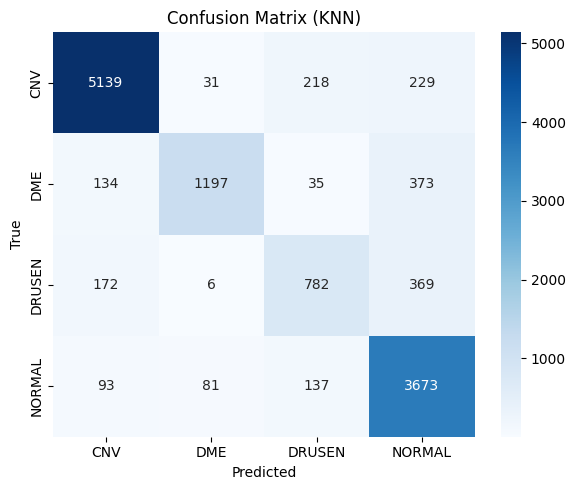

ROC-AUC (OvR): 0.9495


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Evaluate
# -------------------------------
y_pred = knn_pipe.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
f1m    = f1_score(y_test, y_pred, average="macro")
print(f"\n[RESULT] Test Acc={acc:.4f} | Macro-F1={f1m:.4f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=CLASSES, digits=4))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (KNN)")
plt.tight_layout()
plt.show()

# ROC-AUC (OvR) via pseudo-proba from neighbor votes
auc_ovr = None
try:
    if hasattr(knn_pipe[-1], "predict_proba"):
        y_score = knn_pipe.predict_proba(X_test)
        y_bin = label_binarize(y_test, classes=np.arange(len(CLASSES)))
        auc_ovr = roc_auc_score(y_bin, y_score, multi_class="ovr")
except Exception:
    pass
print(f"ROC-AUC (OvR): {auc_ovr:.4f}" if auc_ovr is not None else "ROC-AUC (OvR): N/A")


In [16]:
import numpy as np

# ---- Normalized Confusion Matrix ----
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # row-wise normalization

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (KNN)")
plt.tight_layout()

cm_norm_plot_path = os.path.join(OUT_DIR, "knn_confusion_matrix_normalized.png")
plt.savefig(cm_norm_plot_path, dpi=300)
plt.close()
print(f"[SAVED] {cm_norm_plot_path}")


[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\knn_confusion_matrix_normalized.png


In [15]:
# Define output directory
OUT_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# Save artefacts
# -------------------------------
model_path = os.path.join(OUT_DIR, "knn_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(knn_pipe, f)
print(f"[SAVED] {model_path}")

metrics_path = os.path.join(OUT_DIR, "knn_metrics.csv")
with open(metrics_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric","value"])
    w.writerow(["test_accuracy", f"{acc:.6f}"])
    w.writerow(["test_f1_macro", f"{f1m:.6f}"])
    w.writerow(["train_time_sec", f"{train_time:.3f}"])
    w.writerow(["roc_auc_ovr", f"{auc_ovr:.6f}" if auc_ovr is not None else ""])
print(f"[SAVED] {metrics_path}")

# Save confusion matrix raw values
with open(os.path.join(OUT_DIR, "knn_confusion_matrix.json"), "w") as f:
    json.dump(cm.tolist(), f, indent=2)
print(f"[SAVED] {os.path.join(OUT_DIR, 'knn_confusion_matrix.json')}")

# Save confusion matrix plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (KNN)")
plt.tight_layout()

cm_plot_path = os.path.join(OUT_DIR, "knn_confusion_matrix.png")
plt.savefig(cm_plot_path, dpi=300)
plt.close()
print(f"[SAVED] {cm_plot_path}")


[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\knn_model.pkl
[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\knn_metrics.csv
[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\knn_confusion_matrix.json
[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\knn_confusion_matrix.png
